<a href="https://colab.research.google.com/github/0Nguyen0Cong0Tuan0/Road-Buddy-Challenge/blob/main/models/yolo_model_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **YOLO11 model exploration & performance analysis**

- [Ultralytics YOLO Docs](https://docs.ultralytics.com/)
- [YOLO Training Guide](https://docs.ultralytics.com/modes/train/)
- [Model Export Guide](https://docs.ultralytics.com/modes/export/)


## **YOLO (You Only Look Once) overview**

YOLO is a **real-time object detection** algorithm that
- Processes the entire image in a single forward pass
- Predicts bounding boxes and class probabilities simultaneously
- Is much faster than two-stage detectors (like R-CNN)

### **YOLO11 variants**

| Model | Size | Parameters | Speed | Accuracy | Use Case |
|-------|------|------------|-------|----------|----------|
| YOLO11n | Nano | ~2.6M | Fastest | Good | Edge devices, real-time |
| YOLO11s | Small | ~9.4M | Fast | Better | Mobile, IoT |
| YOLO11m | Medium | ~20.1M | Medium | High | General purpose |
| YOLO11l | Large | ~25.3M | Slower | Higher | High accuracy needed |
| YOLO11x | XLarge | ~56.9M | Slowest | Highest | Maximum accuracy |

**Setup & Installation**

In [2]:
!pip install ultralytics -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.4 MB/s eta 0:00:00


In [3]:
import os
import time
import json
from pathlib import Path
from collections import defaultdict

import torch
import torch.nn as nn
from ultralytics import YOLO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_palette('husl')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


**Load YOLO11 models**

In [4]:
# Load YOLO11 models
# YOLO11n - Nano (smallest, fastest)
model_n = YOLO('yolo11n.pt')
model_l = YOLO('yolo11l.pt')

MODELS = {
    'YOLO11n': model_n,
    'YOLO11l': model_l
}

## **Model architecture**

YOLO models consist of three main parts

1. **Backbone**: Extracts features from input images (like a feature extractor)
2. **Neck**: Aggregates features from different scales (like FPN - Feature Pyramid Network)
3. **Head**: Makes predictions (bounding boxes, class probabilities, confidence)

```
Input Image → [Backbone] → [Neck] → [Head] → Predictions
   (640x640)   (Features)   (Multi-scale)   (Boxes + Classes)
```

In [5]:
def get_model_summary(model, model_name):
    """Extract information about a YOLO model."""
    info = {
        'name': model_name,
        'task': model.task,
        'num_classes': len(model.names),
        'class_names': model.names,
    }

    pytorch_model = model.model

    # Count parameters
    total_params = sum(p.numel() for p in pytorch_model.parameters())
    trainable_params = sum(p.numel() for p in pytorch_model.parameters() if p.requires_grad)

    info['total_params'] = total_params
    info['trainable_params'] = trainable_params
    info['total_params_millions'] = total_params / 1e6

    # Count layers by type
    layer_counts = defaultdict(int)
    for name, module in pytorch_model.named_modules():
        layer_type = type(module).__name__
        layer_counts[layer_type] += 1

    info['layer_counts'] = dict(layer_counts)
    info['total_layers'] = sum(layer_counts.values())

    return info

In [6]:
print("Model architecture summary")
model_summaries = {}

for name, model in MODELS.items():
    summary = get_model_summary(model, name)
    model_summaries[name] = summary

    print(f"\n{name}")
    print(f"   Task: {summary['task']}")
    print(f"   Classes: {summary['num_classes']} (COCO dataset)")
    print(f"   Total Parameters: {summary['total_params']:,} ({summary['total_params_millions']:.2f}M)")
    print(f"   Trainable Parameters: {summary['trainable_params']:,}")
    print(f"   Total Layers: {summary['total_layers']}")

Model architecture summary

YOLO11n
   Task: detect
   Classes: 80 (COCO dataset)
   Total Parameters: 2,624,080 (2.62M)
   Trainable Parameters: 0
   Total Layers: 319

YOLO11l
   Task: detect
   Classes: 80 (COCO dataset)
   Total Parameters: 25,372,160 (25.37M)
   Trainable Parameters: 0
   Total Layers: 631


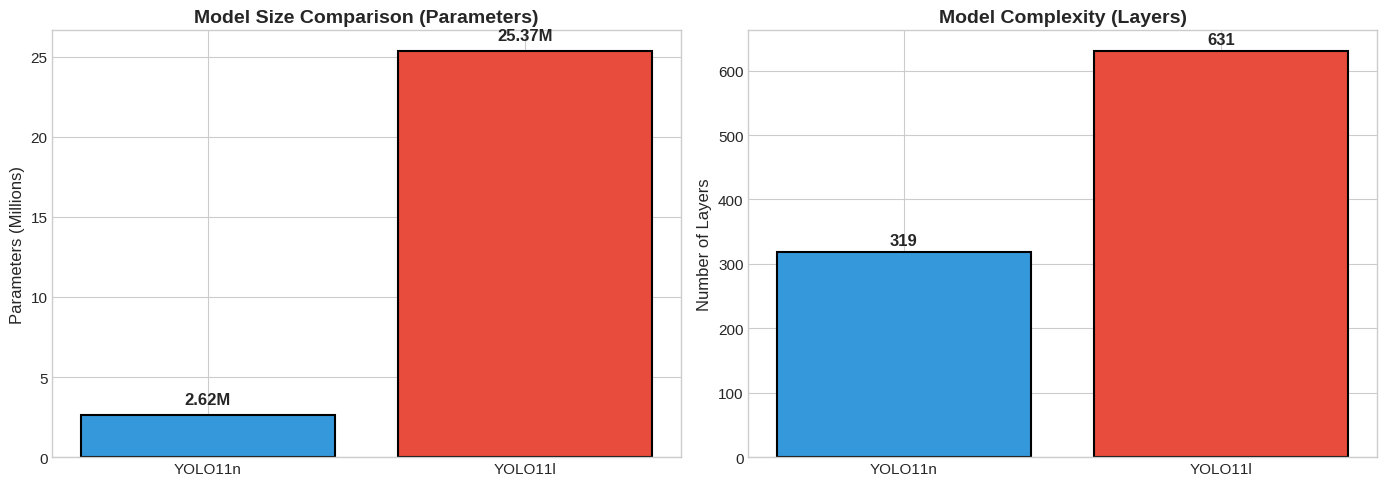

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

model_names = list(model_summaries.keys())
params = [model_summaries[m]['total_params_millions'] for m in model_names]
colors = ['#3498db', '#e74c3c']

bars1 = axes[0].bar(model_names, params, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Parameters (Millions)', fontsize=12)
axes[0].set_title('Model Size Comparison (Parameters)', fontsize=14, fontweight='bold')

# Add value labels on bars
for bar, param in zip(bars1, params):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{param:.2f}M', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Layer comparison
layers = [model_summaries[m]['total_layers'] for m in model_names]

bars2 = axes[1].bar(model_names, layers, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Number of Layers', fontsize=12)
axes[1].set_title('Model Complexity (Layers)', fontsize=14, fontweight='bold')

for bar, layer in zip(bars2, layers):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                 f'{layer}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [8]:
# Combine layer counts from both models
all_layer_types = set()
for summary in model_summaries.values():
    all_layer_types.update(summary['layer_counts'].keys())

# Create comparison dataframe
layer_data = []
for layer_type in sorted(all_layer_types):
    row = {'Layer Type': layer_type}
    for name in model_names:
        row[name] = model_summaries[name]['layer_counts'].get(layer_type, 0)
    layer_data.append(row)

df_layers = pd.DataFrame(layer_data)
df_layers = df_layers.sort_values('YOLO11l', ascending=False).head(15)  # Top 15 layer types

print(df_layers.to_string(index=False))

 Layer Type  YOLO11n  YOLO11l
     Conv2d       88      174
BatchNorm2d       81      167
       Conv       75      161
 Bottleneck       11       32
 Sequential       18       32
        C3k        3       16
 ModuleList       10       10
       C3k2        8        8
   Identity        4        8
     DWConv        6        6
     Concat        4        4
   Upsample        2        2
  Attention        1        2
   PSABlock        1        2
      C2PSA        1        1


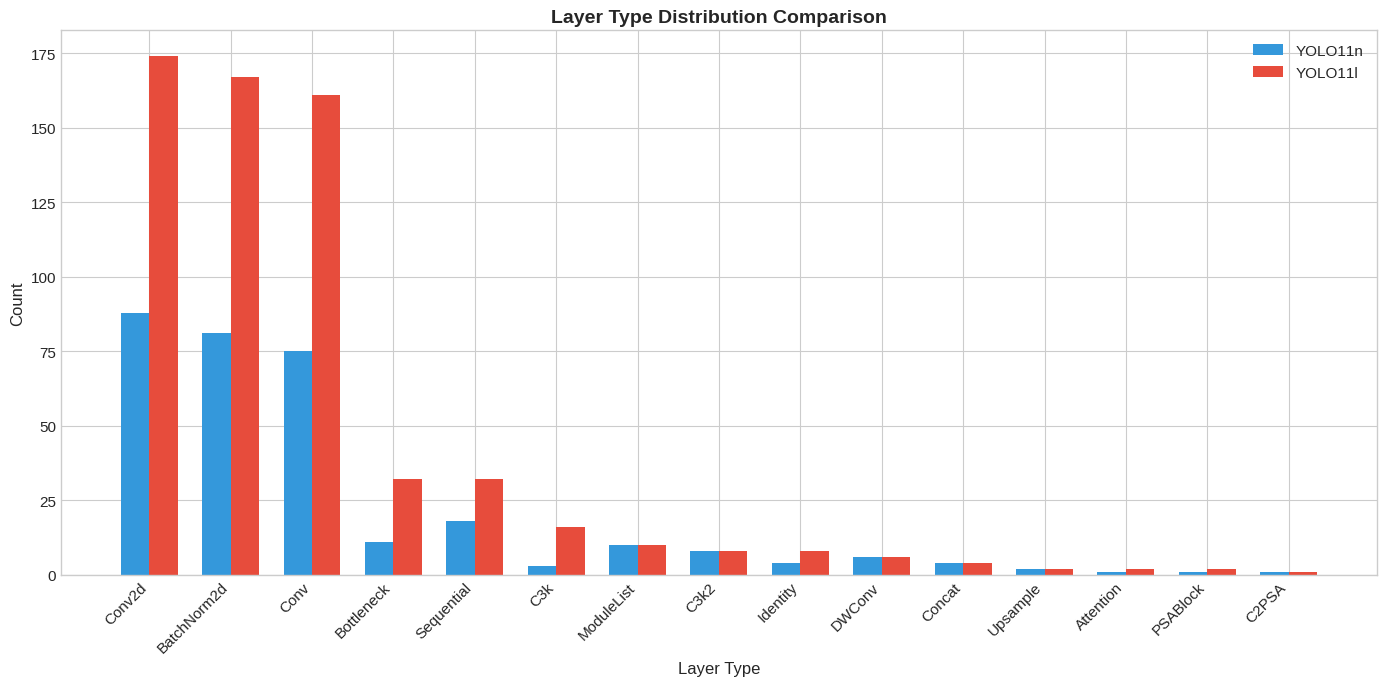

In [9]:
# Visualize layer types
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(df_layers))
width = 0.35

bars1 = ax.bar(x - width/2, df_layers['YOLO11n'], width, label='YOLO11n', color='#3498db')
bars2 = ax.bar(x + width/2, df_layers['YOLO11l'], width, label='YOLO11l', color='#e74c3c')

ax.set_xlabel('Layer Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Layer Type Distribution Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_layers['Layer Type'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

In [10]:
# Show classes that YOLO can detect (COCO dataset classes)
print("\nCOCO Dataset Classes (80 classes)")

class_names = model_n.names
for i, (idx, name) in enumerate(class_names.items()):
    print(f"{idx:2d}: {name:15s}", end="  ")
    if (i + 1) % 5 == 0:
        print()


COCO Dataset Classes (80 classes)
 0: person            1: bicycle           2: car               3: motorcycle        4: airplane         
 5: bus               6: train             7: truck             8: boat              9: traffic light    
10: fire hydrant     11: stop sign        12: parking meter    13: bench            14: bird             
15: cat              16: dog              17: horse            18: sheep            19: cow              
20: elephant         21: bear             22: zebra            23: giraffe          24: backpack         
25: umbrella         26: handbag          27: tie              28: suitcase         29: frisbee          
30: skis             31: snowboard        32: sports ball      33: kite             34: baseball bat     
35: baseball glove   36: skateboard       37: surfboard        38: tennis racket    39: bottle           
40: wine glass       41: cup              42: fork             43: knife            44: spoon            
45: bowl   

## **Performance Testing**

- **Inference speed** (how fast can it process images)
- **Detection results** (what objects are detected)
- **Confidence scores** (how confident is the model)

In [12]:
# Function to run inference and collect metrics
def benchmark_model(model, model_name, images, num_runs=3, warmup=2):
    print(f"\nBenchmarking {model_name}...")

    results = {
        'model_name': model_name,
        'num_images': len(images),
        'inference_times': [],
        'detections_per_image': [],
        'confidence_scores': [],
        'classes_detected': defaultdict(int),
        'all_results': []
    }

    # Warmup runs (to initialize CUDA, etc.)
    print(f"   Warming up ({warmup} runs)...")
    for _ in range(warmup):
        if images:
            _ = model(images[0], verbose=False)

    # Actual benchmark runs
    for run in range(num_runs):
        print(f"   Run {run + 1}/{num_runs}...")

        for img_path in tqdm(images, desc=f"   Processing", leave=False):
            # Measure inference time
            start_time = time.time()
            result = model(img_path, verbose=False)
            inference_time = (time.time() - start_time) * 1000  # Convert to ms

            results['inference_times'].append(inference_time)

            # Collect detection info
            for r in result:
                boxes = r.boxes
                num_detections = len(boxes)
                results['detections_per_image'].append(num_detections)

                if num_detections > 0:
                    # Confidence scores
                    confidences = boxes.conf.cpu().numpy()
                    results['confidence_scores'].extend(confidences.tolist())

                    # Classes detected
                    class_ids = boxes.cls.cpu().numpy().astype(int)
                    for cls_id in class_ids:
                        class_name = model.names[cls_id]
                        results['classes_detected'][class_name] += 1

                # Store last run results for visualization
                if run == num_runs - 1:
                    results['all_results'].append(r)

    # Calculate statistics
    results['avg_inference_time_ms'] = np.mean(results['inference_times'])
    results['std_inference_time_ms'] = np.std(results['inference_times'])
    results['min_inference_time_ms'] = np.min(results['inference_times'])
    results['max_inference_time_ms'] = np.max(results['inference_times'])
    results['fps'] = 1000 / results['avg_inference_time_ms']
    results['avg_detections_per_image'] = np.mean(results['detections_per_image'])
    results['avg_confidence'] = np.mean(results['confidence_scores']) if results['confidence_scores'] else 0

    print(f"Complete! Avg: {results['avg_inference_time_ms']:.1f}ms, FPS: {results['fps']:.1f}")

    return results

In [11]:
POSSIBLE_TEST_PATHS = [
    Path('/content/drive/MyDrive/traffic datasets/Road Lane.v2i.yolo26/test/images'),
    Path('/content/drive/MyDrive/traffic datasets/Kaggle Datasets/bdd100k/bdd100k/bdd100k/images/100k/test/testA'),
]

TEST_IMAGES_DIR = None
for path in POSSIBLE_TEST_PATHS:
    if path.exists():
        TEST_IMAGES_DIR = path
        break

if TEST_IMAGES_DIR and TEST_IMAGES_DIR.exists():
    print(f"Found test images at: {TEST_IMAGES_DIR}")
    test_images = list(TEST_IMAGES_DIR.glob('*.jpg')) + list(TEST_IMAGES_DIR.glob('*.png'))
    print(f"Found {len(test_images)} images")
else:
    print("No test images folder found. Using sample images from URL...")

Found test images at: /content/drive/MyDrive/traffic datasets/Road Lane.v2i.yolo26/test/images
Found 43 images


In [13]:
MAX_TEST_IMAGES = 50
test_images = test_images[:MAX_TEST_IMAGES]
print(f"Using {len(test_images)} test images")

Using 43 test images


In [14]:
benchmark_results = {}

for name, model in MODELS.items():
    benchmark_results[name] = benchmark_model(
        model=model,
        model_name=name,
        images=test_images,
        num_runs=3,
        warmup=2
    )


Benchmarking YOLO11n...
   Warming up (2 runs)...
   Run 1/3...


   Run 2/3...


   Run 3/3...


Complete! Avg: 546.2ms, FPS: 1.8

Benchmarking YOLO11l...
   Warming up (2 runs)...
   Run 1/3...


   Run 2/3...


   Run 3/3...


Complete! Avg: 36.9ms, FPS: 27.1


**Results analysis & visualization**

In [18]:
print(f"Inference Time")

for name, results in benchmark_results.items():
    print(f"\n{name}")
    print(f"  Average: {results['avg_inference_time_ms']:.2f} ms")
    print(f"  Std Dev: {results['std_inference_time_ms']:.2f} ms")
    print(f"  Min: {results['min_inference_time_ms']:.2f} ms")
    print(f"  Max: {results['max_inference_time_ms']:.2f} ms")
    print(f"  FPS (Frames Per Second): {results['fps']:.1f}")
    print(f"  Avg Detections/Image: {results['avg_detections_per_image']:.1f}")
    print(f"  Avg Confidence: {results['avg_confidence']:.2%}")
    print(f"  Total Classes Detected: {len(results['classes_detected'])}")

Inference Time

YOLO11n
  Average: 546.17 ms
  Std Dev: 769.93 ms
  Min: 13.33 ms
  Max: 2023.82 ms
  FPS (Frames Per Second): 1.8
  Avg Detections/Image: 5.9
  Avg Confidence: 54.99%
  Total Classes Detected: 8

YOLO11l
  Average: 36.90 ms
  Std Dev: 2.87 ms
  Min: 32.90 ms
  Max: 55.83 ms
  FPS (Frames Per Second): 27.1
  Avg Detections/Image: 7.4
  Avg Confidence: 59.41%
  Total Classes Detected: 9


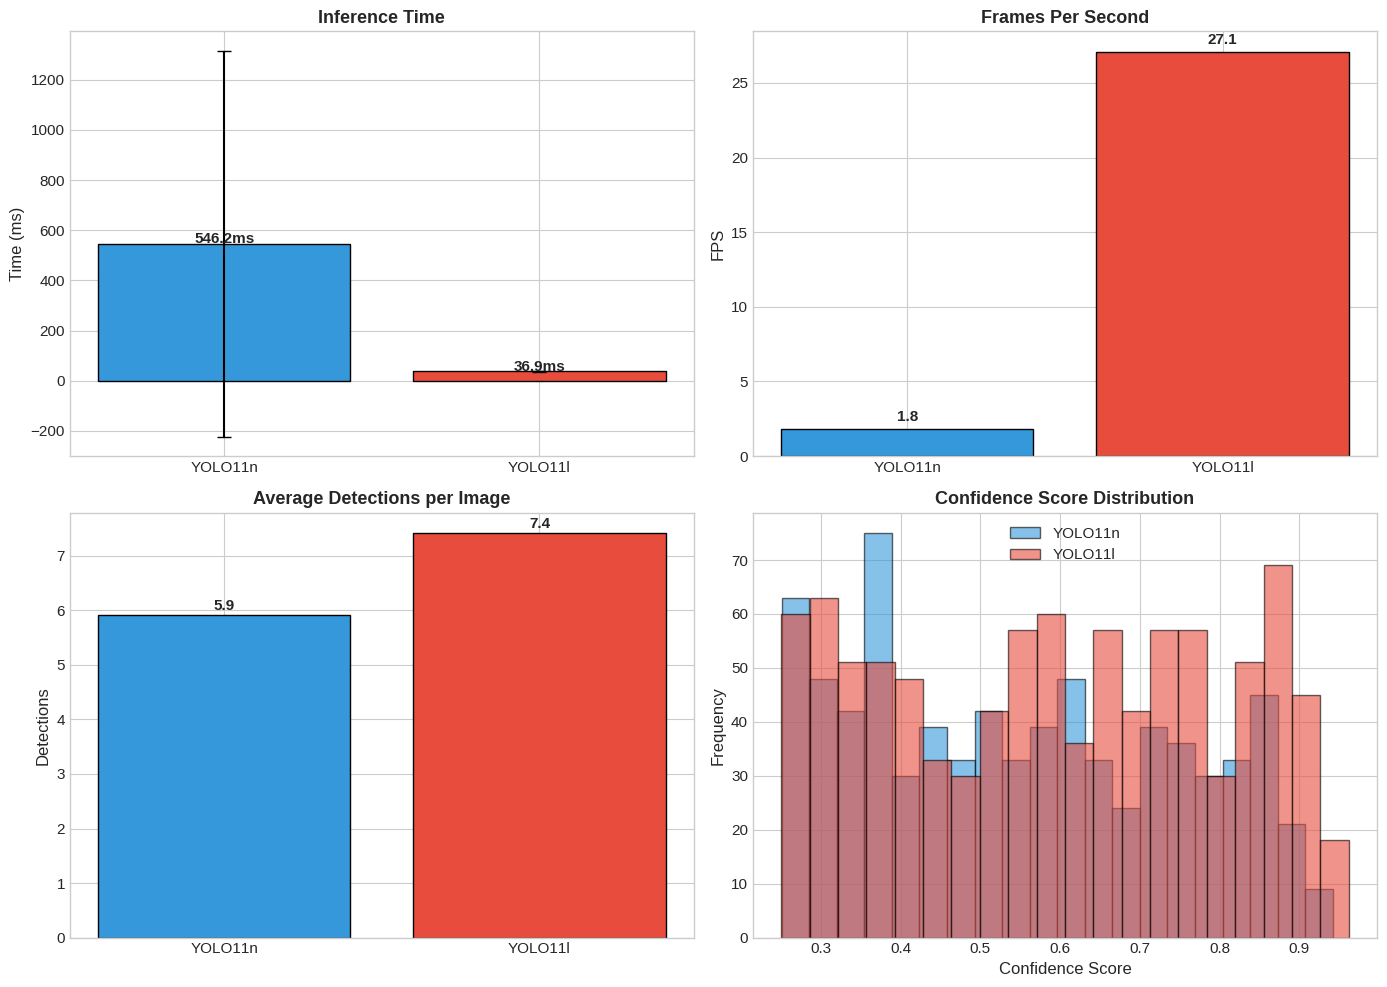

In [23]:
# Visualize performance comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

model_names = list(benchmark_results.keys())
colors = ['#3498db', '#e74c3c']

# Inference Time Comparison
ax = axes[0, 0]
times = [benchmark_results[m]['avg_inference_time_ms'] for m in model_names]
stds = [benchmark_results[m]['std_inference_time_ms'] for m in model_names]
bars = ax.bar(model_names, times, color=colors, edgecolor='black', yerr=stds, capsize=5)
ax.set_ylabel('Time (ms)', fontsize=12)
ax.set_title('Inference Time', fontsize=13, fontweight='bold')
for bar, t in zip(bars, times):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{t:.1f}ms', ha='center', fontsize=11, fontweight='bold')

# FPS Comparison
ax = axes[0, 1]
fps = [benchmark_results[m]['fps'] for m in model_names]
bars = ax.bar(model_names, fps, color=colors, edgecolor='black')
ax.set_ylabel('FPS', fontsize=12)
ax.set_title('Frames Per Second', fontsize=13, fontweight='bold')
for bar, f in zip(bars, fps):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{f:.1f}', ha='center', fontsize=11, fontweight='bold')

# Detections per Image
ax = axes[1, 0]
detections = [benchmark_results[m]['avg_detections_per_image'] for m in model_names]
bars = ax.bar(model_names, detections, color=colors, edgecolor='black')
ax.set_ylabel('Detections', fontsize=12)
ax.set_title('Average Detections per Image', fontsize=13, fontweight='bold')
for bar, d in zip(bars, detections):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{d:.1f}', ha='center', fontsize=11, fontweight='bold')

# Confidence Score Distribution
ax = axes[1, 1]
for name, color in zip(model_names, colors):
    scores = benchmark_results[name]['confidence_scores']
    if scores:
        ax.hist(scores, bins=20, alpha=0.6, label=name, color=color, edgecolor='black')
ax.set_xlabel('Confidence Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Confidence Score Distribution', fontsize=13, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

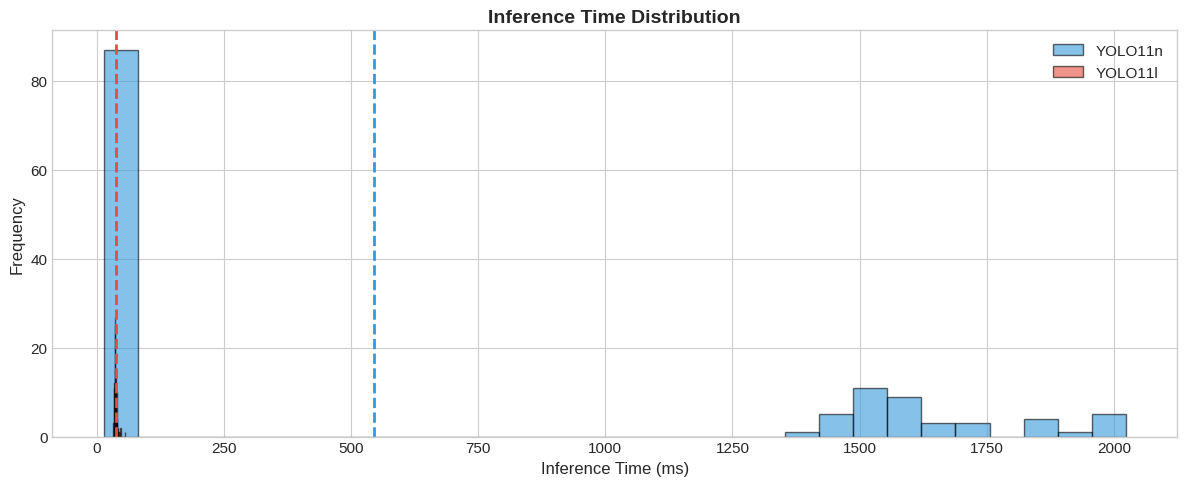

In [25]:
# Inference time distribution
fig, ax = plt.subplots(figsize=(12, 5))

for name, color in zip(model_names, colors):
    times = benchmark_results[name]['inference_times']
    ax.hist(times, bins=30, alpha=0.6, label=name, color=color, edgecolor='black')

ax.set_xlabel('Inference Time (ms)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Inference Time Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.axvline(np.mean(benchmark_results['YOLO11n']['inference_times']), color='#3498db', linestyle='--', linewidth=2, label='YOLO11n Mean')
ax.axvline(np.mean(benchmark_results['YOLO11l']['inference_times']), color='#e74c3c', linestyle='--', linewidth=2, label='YOLO11l Mean')

plt.tight_layout()
plt.show()

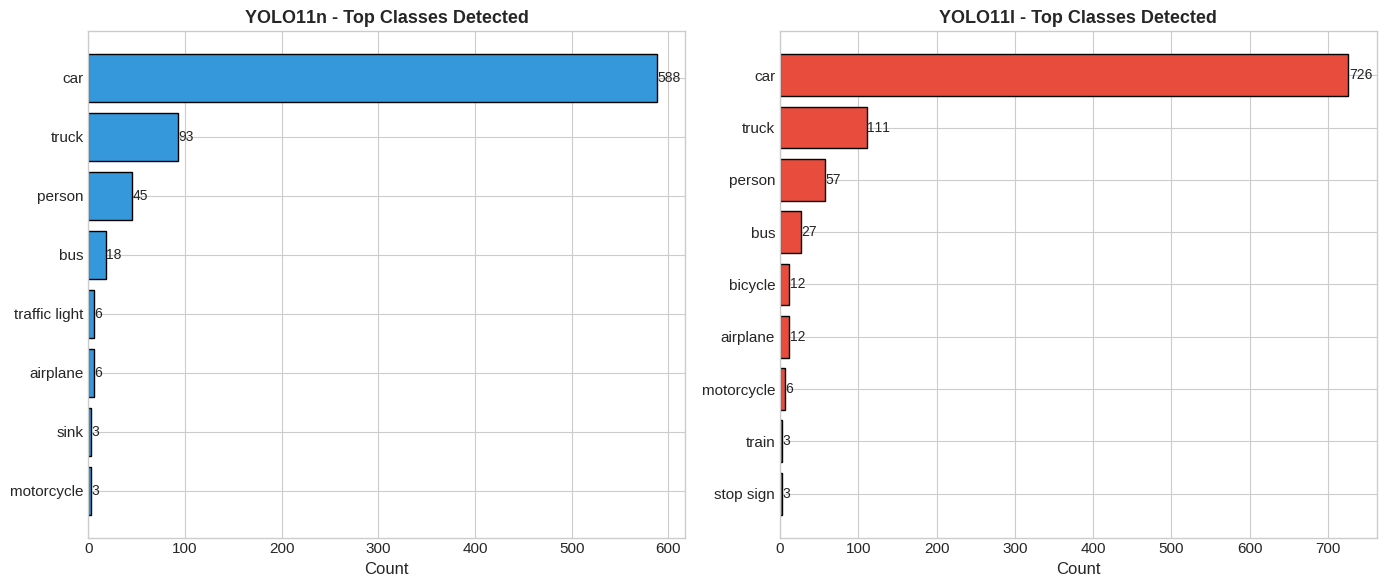

In [28]:
# Classes detected comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (name, color) in enumerate(zip(model_names, colors)):
    ax = axes[idx]
    classes = benchmark_results[name]['classes_detected']

    if classes:
        sorted_classes = sorted(classes.items(), key=lambda x: x[1], reverse=True)[:10]
        class_names_list = [c[0] for c in sorted_classes]
        counts = [c[1] for c in sorted_classes]

        bars = ax.barh(class_names_list, counts, color=color, edgecolor='black')
        ax.set_xlabel('Count', fontsize=12)
        ax.set_title(f'{name} - Top Classes Detected', fontsize=13, fontweight='bold')
        ax.invert_yaxis()

        for bar, count in zip(bars, counts):
            ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                    str(count), va='center', fontsize=10)
    else:
        ax.text(0.5, 0.5, 'No detections', ha='center', va='center', fontsize=14)
        ax.set_title(f'{name}', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

## **Visual detection examples**

In [30]:
def show_detections_comparison(image_source, models_dict, figsize=(16, 6)):
    """Show detection results from multiple models side by side."""
    n_models = len(models_dict)
    fig, axes = plt.subplots(1, n_models + 1, figsize=figsize)

    # Show original image
    if isinstance(image_source, str) and image_source.startswith('http'):
        import urllib.request
        from io import BytesIO
        with urllib.request.urlopen(image_source) as url:
            img = np.array(Image.open(BytesIO(url.read())))
    else:
        img = cv2.imread(str(image_source))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[0].imshow(img)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Show detections from each model
    for idx, (name, model) in enumerate(models_dict.items(), 1):
        results = model(image_source, verbose=False)
        annotated = results[0].plot()

        # Convert BGR to RGB if needed
        if annotated.shape[-1] == 3:
            annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

        axes[idx].imshow(annotated)

        # Count detections
        n_detections = len(results[0].boxes)
        axes[idx].set_title(f'{name}\n({n_detections} detections)', fontsize=12, fontweight='bold')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


Image 1:


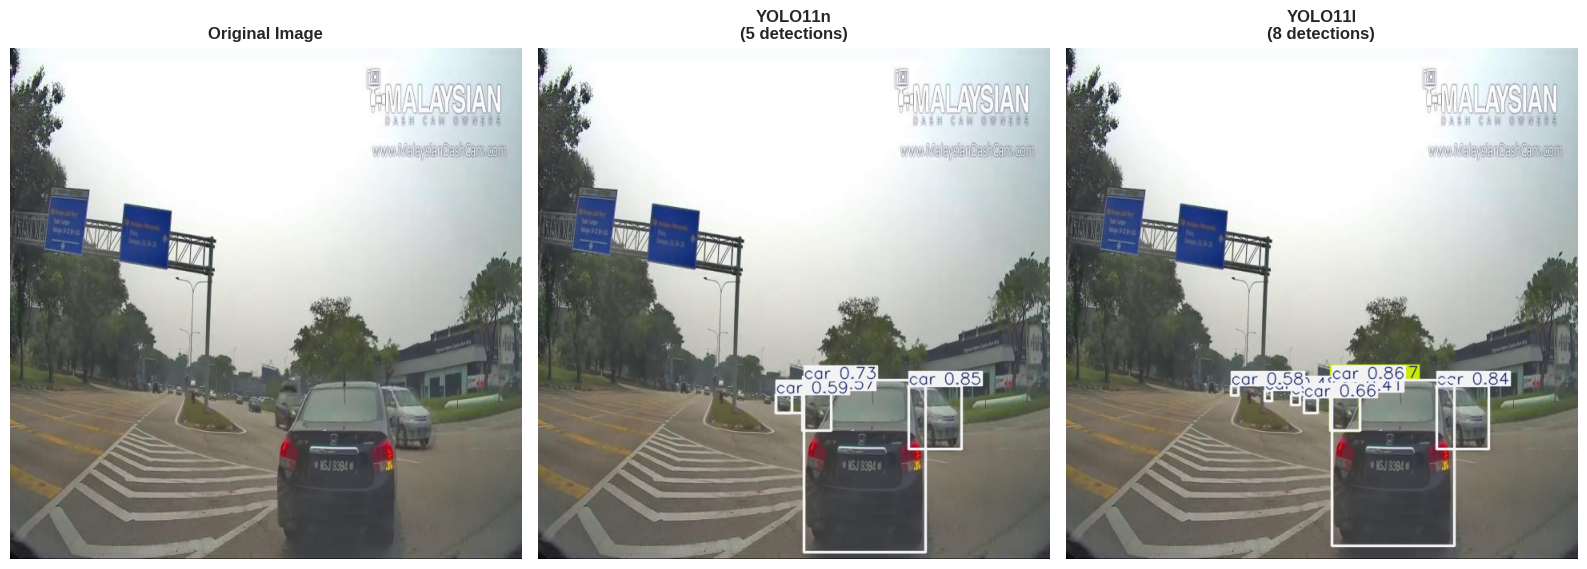


Image 2:


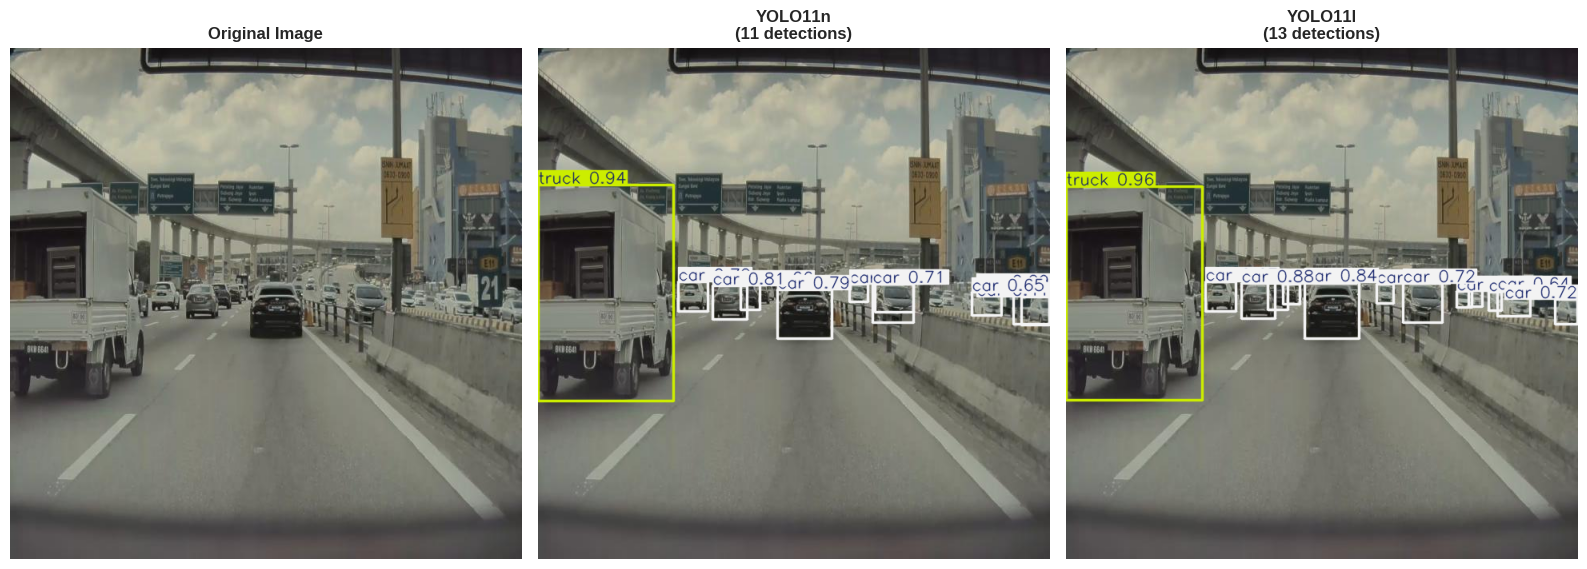


Image 3:


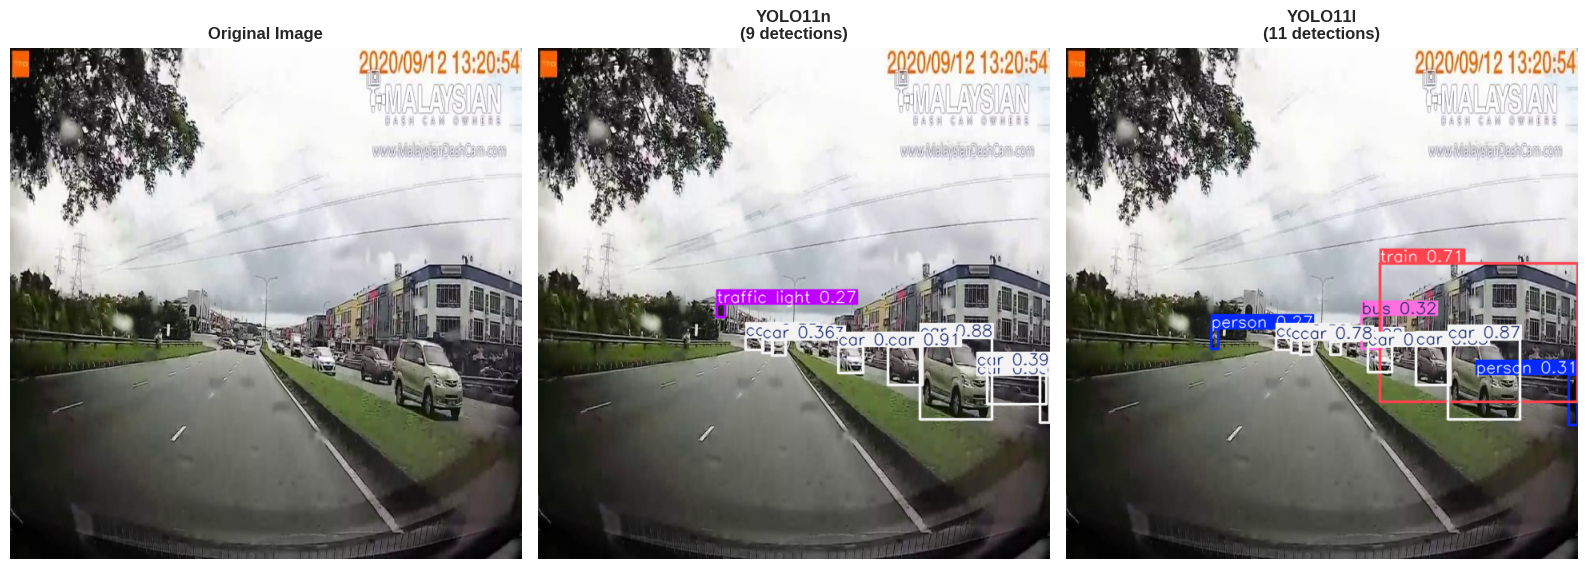

In [32]:
# Show first few test images
num_samples = min(3, len(test_images))

for i, img_source in enumerate(test_images[:num_samples]):
    print(f"\nImage {i+1}:")
    show_detections_comparison(img_source, MODELS)